# Deep Dream

## Deep Dream

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:

* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)
* Google deep dream 참고 : https://github.com/google/deepdream/blob/master/dream.ipynb

In [1]:
import os
import time
import random
import numpy as np
from tqdm import tqdm

import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import Parameter
import mxnet.ndarray as F

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from PIL import Image

%matplotlib inline

mx.random.seed(1)
ctx = mx.cpu()

/Users/jsh/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


## Tools

In [2]:
def load_rgbimage(filename, ctx, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1).astype(float)
    img = F.expand_dims(mx.nd.array(img, ctx=ctx), 0)
    return img

def show_image_rgb(data):
    if data.ndim == 4 and data.shape[0] == 1:
        img = data[0]
    else:
        img = dat
    img = F.clip(img, 0, 255).asnumpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    return img

# Resize image function
def resize_img(img, size):
    import scipy.ndimage
    img = img.copy()
    img = img.asnumpy()
    factors = (1,
               1,
               float(size[0]) / img.shape[2],
               float(size[1]) / img.shape[3])
    return nd.array(scipy.ndimage.zoom(img, factors, order=1))

In [3]:
# Preprocess
def preprocess_img(img, scale=None, mode=None):
    img = img.copy()
    if mode == 'tf':
        img /= 127.5
        img -= 1
        img = np.clip(img, -1., 1.)
    elif scale is not None:
        img /= scale
    else:
        mean = [123.68, 116.779, 103.939]
        img[:, 0, :, :] -= mean[0]
        img[:, 1, :, :] -= mean[1]
        img[:, 2, :, :] -= mean[2]
        img = nd.clip(img, -127.5, 127.5)
    return img 

# Deprocess
def deprocess_img(img, scale=None, mode=None):
    img = img.copy()
    if scale is not None:
        img *= scale
    elif mode == 'tf':
        img += 1
        img *= 127.5
    else:
        mean = [123.68, 116.779, 103.939]
        img[:, 0, :, :] += mean[0]
        img[:, 1, :, :] += mean[1]
        img[:, 2, :, :] += mean[2]
    img = nd.clip(img, 0, 255)
    return img

In [4]:
def imagenet_clamp_batch(batch, low, high, norm=True):
    if norm:
        F.clip(batch[:,0,:,:],low-123.680, high-123.680)
        F.clip(batch[:,1,:,:],low-116.779, high-116.779)
        F.clip(batch[:,2,:,:],low-103.939, high-103.939)
    else:
        F.clip(batch[:,0,:,:],low, high)
        F.clip(batch[:,1,:,:],low, high)
        F.clip(batch[:,2,:,:],low, high)

### Load image data

In [33]:
# Load image data
img_path = os.getcwd()+'/img/sky.jpeg'
input_img = load_rgbimage(img_path, ctx, keep_asp = True)

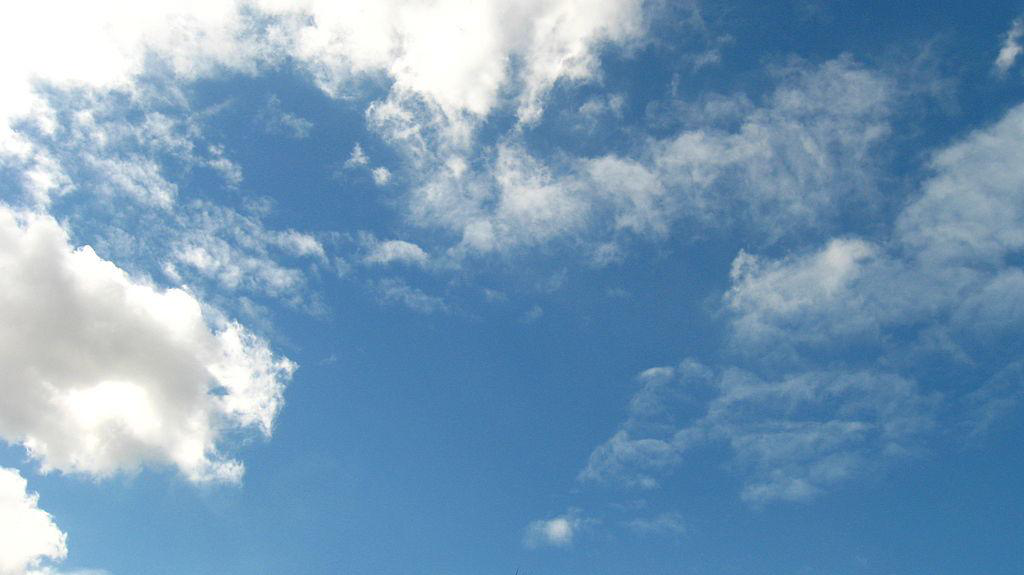

In [6]:
show_image_rgb(input_img)

In [7]:
input_img.shape # (batch, channel, height, width)

(1, 3, 575, 1024)

## Deep dream (first try..)

In [19]:
class FirstDream(gluon.Block):
    def __init__(self,**kwargs):
        super(FirstDream,self).__init__(**kwargs)
        with self.name_scope():
            self.vgg_layers = mx.gluon.model_zoo.vision.vgg16(pretrained=True, ctx=ctx, 
                                                              root='~/DS/git/dl_study_with_gluon/models').features
            self.layer_name_mapping = {
            #'4': "pool_1",
            #'9': 'pool_2',
            #'16' : 'pool_3',
            '23' : 'pool_4',
            '30' : 'pool_5'
        }
    
    def forward(self, x):
        output = []
        ## pool layer output 추출
        for i in range(31):
            x = self.vgg_layers[i](x)
            if str(i) in self.layer_name_mapping:
                output.append(x)
        return output

In [20]:
# gradient 값을 기준으로 하여 input image를 변화 시켜야 함 -->  input image를 parameter 형태로 변환하여  gradient 값을 바탕으로 update가 이루어지도록 함
output = Parameter('output', shape=input_img.shape)
output.initialize(ctx=ctx)
output.set_data(input_img.copy())

# optimizer
lr = 1000000
trainer = gluon.Trainer([output], 'sgd', {'learning_rate': lr})

In [21]:
num_layers = 2
num_iteration = 10
fdream = FirstDream()
fdream.vgg_layers.collect_params().setattr('grad_req', 'null')

begin_time = time.time()
for i in range(num_iteration):
    start_time = time.time()
    imagenet_clamp_batch(output.data(), 0, 255, norm=False)
    # fix BN for pre-trained vgg
    with autograd.record():
        for j in range(num_layers):
            pool_output = fdream(output.data())[j] # last pool layer output
            # optimize the gradient of the mean of the selected layer's activation for each of the pooling layers
            loss = -nd.mean(pool_output)
    loss.backward()
    print('epoch:', str(i), ', Loss:', "{0:.2f}".format(loss.asscalar()), ', Time:', "%s secs" % (time.time() - start_time))
    trainer.step(1) # batch_size = 1
print("--- %s seconds ---" % (time.time() - begin_time))

epoch: 0 , Loss: -0.66 , Time: 15.193248987197876 secs
epoch: 1 , Loss: -1.26 , Time: 23.07502007484436 secs
epoch: 2 , Loss: -2.06 , Time: 21.02093744277954 secs
epoch: 3 , Loss: -2.97 , Time: 18.623644828796387 secs
epoch: 4 , Loss: -3.97 , Time: 20.133737087249756 secs
epoch: 5 , Loss: -5.20 , Time: 20.39091992378235 secs
epoch: 6 , Loss: -6.68 , Time: 17.509599924087524 secs
epoch: 7 , Loss: -8.36 , Time: 16.172388076782227 secs
epoch: 8 , Loss: -10.47 , Time: 14.892173767089844 secs
epoch: 9 , Loss: -12.76 , Time: 14.411273956298828 secs
--- 181.438570022583 seconds ---


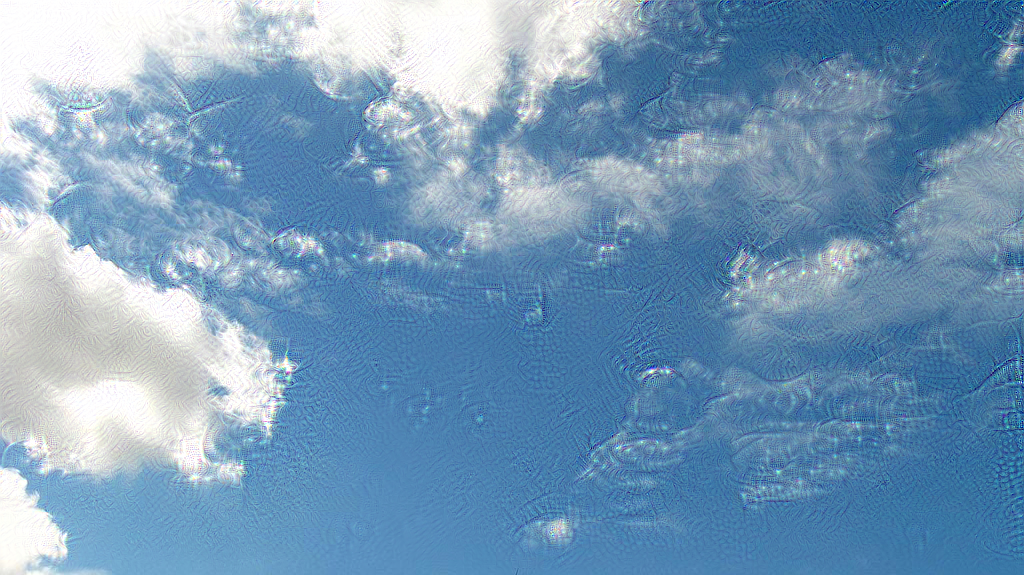

In [22]:
#show changed image
show_image_rgb(output.data())

## Deep dream with InceptionV3 model
* InceptionV3 참고 : https://chaosmail.github.io/caffejs/models.html
* We will maximize a weighted sum of the L2 norm of the activations of a set of high-level layers.

In [23]:
inception = mx.gluon.model_zoo.vision.inception_v3(pretrained=True, ctx=ctx, root='~/DS/git/dl_study_with_gluon/models').features
inception

HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(3 -> 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm(axis=1, eps=0.001, momentum=0.9, fix_gamma=False, in_channels=32)
    (2): Activation(relu)
  )
  (1): HybridSequential(
    (0): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=0.001, momentum=0.9, fix_gamma=False, in_channels=32)
    (2): Activation(relu)
  )
  (2): HybridSequential(
    (0): Conv2D(32 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=0.001, momentum=0.9, fix_gamma=False, in_channels=64)
    (2): Activation(relu)
  )
  (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): HybridSequential(
    (0): Conv2D(64 -> 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=0.001, momentum=0.9, fix_gamma=False, in_channels=80)
    (2): Activation(relu)
  )
  (5): HybridSequential(
    (0): Con

In [25]:
class DeepDream(gluon.Block):
    def __init__(self,**kwargs):
        super(DeepDream,self).__init__(**kwargs)
        with self.name_scope():
            self.inception_layers = mx.gluon.model_zoo.vision.inception_v3(pretrained=True, ctx=ctx, 
                                                            root='~/DS/git/dl_study_with_gluon/models').features
            self.layer_name_mapping = {
                 '9': 'concat2',
                '10': 'concat3',
                '11' : 'concat4',
                '12' : 'concat5'
            }
    
    def forward(self, x):
        output = []
        ## pool layer output 추출
        for i in range(13):
            x = self.inception_layers[i](x)
            if str(i) in self.layer_name_mapping:
                output.append(x)
        return output

In [36]:
dream = DeepDream()
num_iteration = 10 
num_layers = 4
lr = 0.01

# how much the layer's activation will contribute to the loss
layer_contributions = [0.2, 3., 2., 1.5]

# Do not update the pretrained model
dream.inception_layers.collect_params().setattr('grad_req', 'null')

## Different Octave Scales
* 출처 : https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.2-deep-dream.ipynb
![Img](./deep_dream_octave.png)

In [27]:
# 매 octave마다 이전 이미지와 1.4배(octave_scale)씩 차이나도록
num_octave = 3
octave_scale = 1.4 

In [28]:
# Make a set of shapes
original_shape = input_img.shape[2:4]
shape_set = [original_shape]
for i in range(1, num_octave):
    new_shape = tuple([int(dim / octave_scale ** i) for dim in original_shape])
    shape_set.append(new_shape)
    
# 가장 작은 이미지 사이즈부터 시작
shape_set = shape_set[::-1]

In [29]:
shape_set

[(293, 522), (410, 731), (575, 1024)]

In [37]:
original_img = preprocess_img(input_img.copy(), mode='tf')
shrunk_img = resize_img(original_img, shape_set[0]) 

## Gradient ascent
* Define a loss as the weighted sum of the L2-norm of the activations of the layers that we selected above.
* Maximize the loss using gradient ascent

In [30]:
def gradient_ascent(x, ctx, num_layers, num_iteration, learning_rate):
    x = x.copy()
    # Define parameter
    output = Parameter('output', shape=x.shape)
    output.initialize(ctx=ctx)

    begin_time = time.time()
    # optimizing the images
    for j in range(num_iteration):
        output.set_data(x)
        start_time = time.time()
        #imagenet_clamp_batch(output.data(), low=-1, high=1, norm=False)
        with autograd.record():  
            loss = 0  
            for i in range(num_layers):
                layer_output = dream(output.data())[i]
                coeff = layer_contributions[i]
                scaling = F.prod(nd.array(layer_output.shape))
                # Avoid border artifacts by only involving nonborder pixels in the loss
                loss = loss + coeff * F.sum(F.square(layer_output[:, :, 2: -2, 2: -2])) / scaling 
        loss.backward()
        
        grad = output.data().grad
        grad /= F.maximum(F.mean(F.abs(grad)), 1e-7)
        x += learning_rate * grad
        print('epoch:', str(j), ', Loss:', "{0:.2f}".format(loss.asscalar()), ', Time:', "%s secs" % (time.time() - start_time))

    print("--- %s seconds ---" % (time.time() - begin_time))
    return x

In [38]:
for i, shape in enumerate(shape_set):
    print('Step', str(i), ': Image shape', shape)
    input_img = resize_img(input_img, shape)
    # Gradient ascent step
    input_img = gradient_ascent(input_img, ctx=ctx, num_layers=num_layers, num_iteration=num_iteration, 
                                learning_rate=lr) 
    
    # 이미지 resize 이후 blurry한 것을 보완하기 위해 원본 이미지를 활용해 upscaling 이후 손실한 디테일을 다시 채워줌
    if i > 0:
        # Scales up the smaller version of the original image
        upscale_shrunk_img = resize_img(shrunk_img, shape)
        # Computes the high-quality version of the original image at this size
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscale_shrunk_img 
        input_img += lost_detail 
        shrunk_img = resize_img(original_img, shape)

Step 0 : Image shape (293, 522)
epoch: 0 , Loss: 1.92 , Time: 1.5809600353240967 secs
epoch: 1 , Loss: 2.33 , Time: 3.0646209716796875 secs
epoch: 2 , Loss: 2.58 , Time: 3.1157431602478027 secs
epoch: 3 , Loss: 2.78 , Time: 3.338775157928467 secs
epoch: 4 , Loss: 2.91 , Time: 3.0231711864471436 secs
epoch: 5 , Loss: 3.02 , Time: 3.0960562229156494 secs
epoch: 6 , Loss: 3.12 , Time: 3.030245065689087 secs
epoch: 7 , Loss: 3.21 , Time: 3.013838052749634 secs
epoch: 8 , Loss: 3.29 , Time: 2.9986732006073 secs
epoch: 9 , Loss: 3.37 , Time: 3.0287928581237793 secs
--- 29.2950279712677 seconds ---
Step 1 : Image shape (410, 731)
epoch: 0 , Loss: 2.48 , Time: 2.7198169231414795 secs
epoch: 1 , Loss: 2.81 , Time: 6.387247085571289 secs
epoch: 2 , Loss: 3.02 , Time: 6.454306125640869 secs
epoch: 3 , Loss: 3.16 , Time: 6.50039005279541 secs
epoch: 4 , Loss: 3.28 , Time: 6.439598798751831 secs
epoch: 5 , Loss: 3.37 , Time: 6.462623834609985 secs
epoch: 6 , Loss: 3.46 , Time: 6.587193012237549 sec

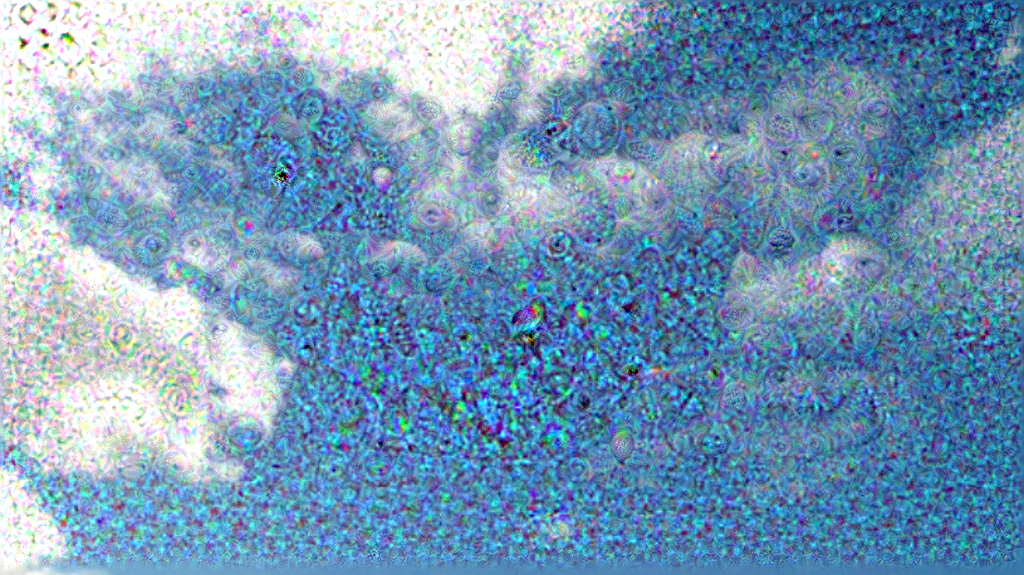

In [39]:
#show changed image
show_image_rgb(deprocess_img(input_img, mode='tf'))

### 참고 (Keras result)
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.2-deep-dream.ipynb
![Img2](./dream_keras.png)